In [ ]:
!pip install -q tensorflow_text

In [ ]:
!python -m spacy download en_core_web_md

2023-01-12 18:39:47.384326: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-01-12 18:39:47.384453: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-01-12 18:39:47.384478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 6.8 MB/s 

In [ ]:
import pathlib 
import warnings
import os
import io
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

import tensorflow_text
import tensorflow as tf 
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score,confusion_matrix,ConfusionMatrixDisplay,classification_report

Scammers send fake text messages to trick you into giving them your personal information – things like your password, account number, or Social Security number. If they get that information, they could gain access to your email, bank, or other accounts.

Spam Detection is a binary classification problem. The reason to do this is simple: by detecting unsolicited and unwanted messages, we can prevent spam messages from creeping into the user's inbox, thereby improving user experience.

In [ ]:
df = pd.read_csv('./spam.csv', encoding='ISO-8859-1')
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [ ]:
df.groupby('v1').describe()

v2                                                                 \
     count unique                                                top freq   
v1                                                                          
ham   4825   4516                             Sorry, I'll call later   30   
spam   747    653  Please call our customer service representativ...    4   

     Unnamed: 2                                                            \
          count unique                                                top   
v1                                                                          
ham          45     39   bt not his girlfrnd... G o o d n i g h t . . .@"   
spam          5      4                                        PO Box 5249   

          Unnamed: 3                                    Unnamed: 4         \
     freq      count unique                    top freq      count unique   
v1                                                                          
ham     3         10      9                     GE    2          6      5   
spam    2          2      1   MK17 92H. 450Ppw 16"    2          0      0   

                    
          top freq  
v1                  
ham   GNT:-)"    2  
spam      NaN  NaN

In [ ]:
df['length']=df['v2'].apply(len)
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,length
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,111
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,155
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,61


Let's drop those three unnamed columns as they won't bring much to our model building anyways.

In [ ]:
df = df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])
df = df.rename(columns={'v1':'label','v2':'message'})

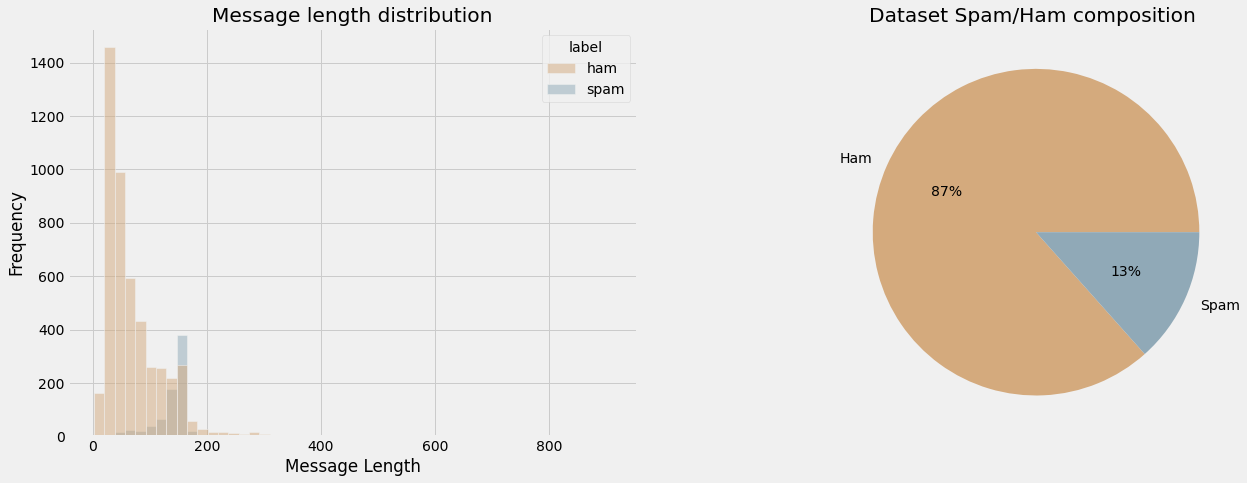

In [ ]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7))
sns.histplot(data=df, x="length",
             hue="label",
             bins=50,
             ax=ax[0],
             palette=['#D4AA7D',"#90A9B7"],
             legend=True).set_title('Message length distribution')
ax[0].set_xlabel('Message Length')
ax[0].set_ylabel('Frequency')

ax[1].pie(df.label.value_counts(normalize=True), 
            labels = ['Ham','Spam'], 
            autopct='%0.f%%', 
            colors=['#D4AA7D',"#90A9B7"]
            )
ax[1].set_title('Dataset Spam/Ham composition ')
plt.show()

In [ ]:
nlp = en_core_web_sm.load()

In [ ]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df["message_clean"] = df["message"].apply(Clean)

#some combination of characters are still remaining from special characters' html tags 
df['message_clean'] = df['message_clean'].str.replace('lt gt', '')
df['message_clean'] = df['message_clean'].str.replace(' amp ', ' ')

#removing stop words
df["message_clean"] = df["message_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

In [ ]:
df['length_clean']=df['message_clean'].apply(len)
df.head()

,label,message,length,message_clean,length_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,75
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,23
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...,103
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c,19
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah don t think usf live,24


In [ ]:
df[df.label=='ham'].describe()

,length,length_clean
count,4825.000000,4825.000000
mean,71.023627,36.185907
std,58.016023,31.214779
min,2.000000,0.000000
25%,33.000000,16.000000
50%,52.000000,27.000000
75%,92.000000,47.000000
max,910.000000,366.000000


In [ ]:
df[df.label=='spam'].describe()

,length,length_clean
count,747.000000,747.000000
mean,138.866131,80.048193
std,29.183082,22.615929
min,13.000000,4.000000
25%,132.500000,69.000000
50%,149.000000,81.000000
75%,157.000000,96.000000
max,224.000000,134.000000


In [ ]:
df[df.length == 910].message.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [ ]:
df[df.length == 910].message_clean.iloc[0]

'love start attraction feel need time thing come thought start day end time dream love breath life happen life cry happiness sorrow ready fight love crazy thing love don t proove girl beautiful lady planet singe praise love start chicken curry end makie sambar life beautiful morning thank god day like lot tell later'

In [ ]:
df[df.length == 224].message.iloc[0]

'Good afternoon on this glorious anniversary day, my sweet J !! I hope this finds you happy and content, my Prey. I think of you and send a teasing kiss from across the sea coaxing images of fond souveniers ... You Cougar-Pen'

In [ ]:
df[df.length == 224].message_clean.iloc[0]

'good afternoon glorious anniversary day sweet j hope find happy content prey think send teasing kiss sea coax image fond souvenier cougar pen'

In [ ]:
df_ham  = df[df['label'] == 'ham'].copy()
df_spam = df[df['label'] == 'spam'].copy()

In [ ]:
from wordcloud import WordCloud

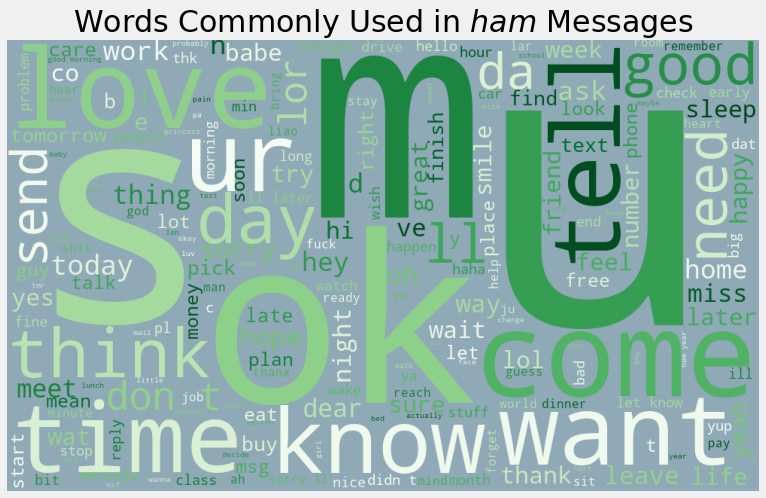

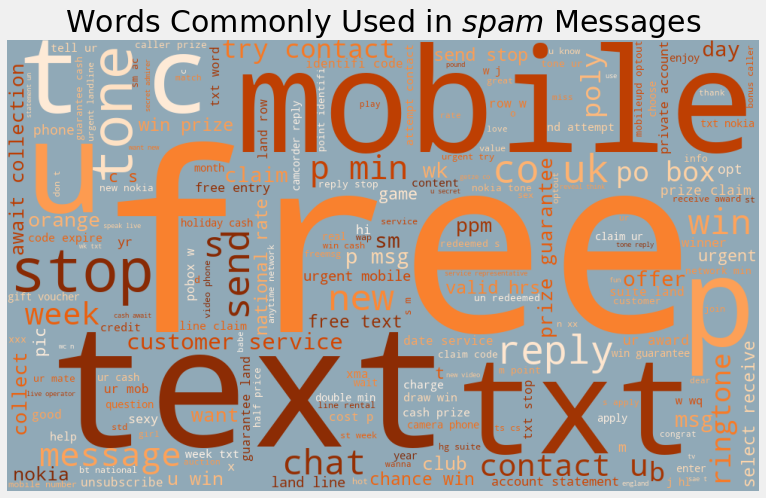

In [ ]:
for label, cmap in zip(["ham", "spam"], ["Greens","Oranges"]):
    text = df.query("label == @label")["message_clean"].str.cat(sep=" ")
    plt.figure(figsize=(12, 8))
    wc = WordCloud(width=1000, height=600, background_color="#90A9B7", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=30)
    plt.show()

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" alt="Precision & Recall"/>
</p>



## What is the problem here?
we have an imbalanced dataset, most of our data points have the label of ham, and it is natural. becuase most of sms are ham. in this cases, accuracy can't be a good metric. we need to see other metrics.

## But what metric is better option?
in this probelm, false negetive and false positive are important. the metrics that give us the power of calcuating them are precision and recall, but there is one metric more, `f1-score`

## Why f1-score?
f1-score is the harmonic mean of precision and recall, so with one shot we can both two.

f1-score formula: $F_1 = 2 \times \frac{precision \times recall}{precision + recall}$

---

In [ ]:
for token in nlp(df['message_clean'][0]) : 
  print(token.lemma_) 

jurong
point
crazy
available
bugis
n
great
world
la
e
buffet
cine
amore
wat


In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(df.message_clean)

df["message_enc"] = tokenizer.texts_to_sequences(df.message_clean)
df["category"] = df["label"].apply(lambda x: 1 if x=="spam" else 0)
df.head()

,label,message,length,message_clean,length_clean,message_enc,category
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,75,"[1, 251, 460, 432, 960, 28, 56, 204, 721, 76, ...",0
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,23,"[8, 215, 1, 305, 2, 1]",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...,103,"[11, 297, 541, 627, 25, 1, 786, 433, 1, 129, 1...",1
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c,19,"[2, 130, 161, 1, 2, 50]",0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah don t think usf live,24,"[722, 31, 5, 21, 668, 137]",0


In [ ]:
message_pad = tf.keras.preprocessing.sequence.pad_sequences(df.message_enc, padding="post")

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(message_pad,df.category, test_size=0.1)

train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [ ]:
for sms, categ in train_batch.take(1):
  print(sms, categ)

tf.Tensor(
[[573 111  14 ...   0   0   0]
 [  7  80   1 ...   0   0   0]
 [ 57  37 442 ...   0   0   0]
 ...
 [ 26   3 151 ...   0   0   0]
 [  4   0   0 ...   0   0   0]
 [147  85   1 ...   0   0   0]], shape=(64, 72), dtype=int32) tf.Tensor(
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0], shape=(64,), dtype=int64)


In [ ]:
sms.shape[1]

72

---

#Establishing a basseline

Let's look at some implementations of classic classification algorithms and how they fare with SMS Spam detection. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [ ]:
lr = LogisticRegression(max_iter=1500)
lr.fit(xtrain,ytrain)
pred_logreg = lr.predict(xval)

print(classification_report(yval,pred_logreg))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       474
           1       0.53      0.24      0.33        84

    accuracy                           0.85       558
   macro avg       0.70      0.60      0.62       558
weighted avg       0.82      0.85      0.83       558



In [ ]:
nb = MultinomialNB()
nb.fit(xtrain,ytrain)
pred_nb = nb.predict(xval)

print(classification_report(yval,pred_nb))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       474
           1       0.40      0.58      0.48        84

    accuracy                           0.81       558
   macro avg       0.66      0.72      0.68       558
weighted avg       0.84      0.81      0.82       558



# Embedding model

In [ ]:
vocab_size = tokenizer.num_words

In [ ]:
# model_1 = tf.keras.Sequential([
#                   tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[sms.shape[1]],name="embedding"),
#                   tf.keras.layers.GlobalMaxPooling1D(),
#                   tf.keras.layers.Dense(16, activation='relu'),
#                   tf.keras.layers.Dense(1, activation="sigmoid")
#                             ])

In [ ]:
model_1 = tf.keras.Sequential([
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[sms.shape[1]],name="embedding"),
                  tf.keras.layers.GlobalMaxPooling1D(),
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(1, activation="sigmoid")
                            ])

In [ ]:
optimizer= tf.keras.optimizers.Adam()

model_1.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy
              ()])

In [ ]:
history_1 = model_1.fit(train_batch, epochs=50, validation_data=val_batch, batch_size=64)

Epoch 1/50
79/79 [==============================] - 9s 87ms/step - loss: 0.4366 - binary_accuracy: 0.8610 - val_loss: 0.3425 - val_binary_accuracy: 0.8495
Epoch 2/50
79/79 [==============================] - 3s 41ms/step - loss: 0.1759 - binary_accuracy: 0.9218 - val_loss: 0.1281 - val_binary_accuracy: 0.9677
Epoch 3/50
79/79 [==============================] - 1s 17ms/step - loss: 0.0412 - binary_accuracy: 0.9910 - val_loss: 0.1010 - val_binary_accuracy: 0.9767
Epoch 4/50
79/79 [==============================] - 1s 16ms/step - loss: 0.0147 - binary_accuracy: 0.9958 - val_loss: 0.1164 - val_binary_accuracy: 0.9731
Epoch 5/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0076 - binary_accuracy: 0.9984 - val_loss: 0.1239 - val_binary_accuracy: 0.9731
Epoch 6/50
79/79 [==============================] - 1s 7ms/step - loss: 0.0037 - binary_accuracy: 0.9992 - val_loss: 0.1286 - val_binary_accuracy: 0.9749
Epoch 7/50
79/79 [==============================] - 0s 5ms/step - loss: 

In [ ]:
#setting a color chart for the seaborn plots
color_chart = ["#D4AA7D", "#EFD09E", "#90A9B7", "#D2D8B3"]

#Plotting loss and accuracy over epochs
fig = go.Figure(data=[
                      go.Scatter(
                          y=history_1.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                          color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_1.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          )),
                      go.Scatter(
                          y=history_1.history["binary_accuracy"],
                          name="Training accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[2]
                          )),
                      go.Scatter(
                          y=history_1.history["val_binary_accuracy"],
                          name="Validation accruracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[3]
                          ))
                      ])
fig.update_layout(
                  title='Training and val loss across epochs',
                  xaxis_title='epochs',
                  yaxis_title='Cross Entropy'    
                  )
fig.show()

In [ ]:
# Use the model to predict whether a message is spam
messages_received = ['Greg, can you call me back once you get this?',
                      'Congrats on your new iPhone! Click here to claim your prize...', 
                      'Really like that new photo of you',
                      'Did you hear the news today? Terrible what has happened...',
                      'Attend this free COVID webinar today: Book your session now...']


# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(messages_received)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=sms.shape[1])           

fakes_prediction = model_1.predict(fakes_padded)

# The closer the class is to 1, the more likely that the message is spam
for x in range(len(messages_received)):
  print(messages_received[x])
  print(fakes_prediction[x])
  print('\n')

1/1 [==============================] - 0s 63ms/step
Greg, can you call me back once you get this?
[3.9445886e-06]


Congrats on your new iPhone! Click here to claim your prize...
[0.9999964]


Really like that new photo of you
[0.00928095]


Did you hear the news today? Terrible what has happened...
[0.04035925]


Attend this free COVID webinar today: Book your session now...
[0.04125503]




In [ ]:
preds = model_1.predict(xval)
preds = preds.reshape(-1)
results_1 = pd.DataFrame({'test':yval,'pred':preds})
results_1['pred'] = round(results_1['pred'])
print(classification_report(results_1.test,results_1.pred))

18/18 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       474
           1       0.93      0.90      0.92        84

    accuracy                           0.97       558
   macro avg       0.96      0.95      0.95       558
weighted avg       0.97      0.97      0.97       558



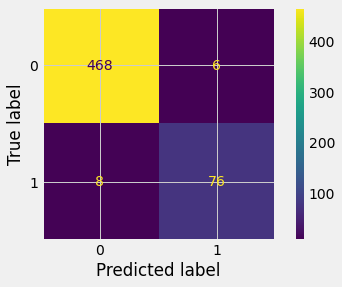

In [ ]:
cm_test = confusion_matrix(results_1.test,results_1.pred)
ConfusionMatrixDisplay(cm_test).plot()
plt.show()

# Transfer Learning : BERT Model

In [ ]:
text_test = [df.message_clean[5]]

preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
text_preprocessed = bert_preprocessor(text_test)

In [ ]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

In [ ]:
model_tlbert = tf.keras.Model(inputs = [text_input], outputs = [outputs])

In [ ]:
model_tlbert.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['Inputs[0][0]']                 
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

model_tlbert.compile(optimizer ='adam',
               loss = 'binary_crossentropy',
               metrics = Metrics)

In [ ]:
# Train test split per text 
text_train, text_test, y_train, y_test = train_test_split(df.message_clean, df.category, test_size=0.1, random_state=1,stratify=df.category)

text_train, text_val, y_train, y_val = train_test_split(text_train, y_train, test_size=0.1, random_state=1,stratify=y_train)

# creating tensorflow datasets slices and making batches

text_train_ds = tf.data.Dataset.from_tensor_slices((text_train, y_train))
text_test_ds = tf.data.Dataset.from_tensor_slices((text_test, y_test))
text_val_ds = tf.data.Dataset.from_tensor_slices((text_val, y_val))

text_train_ds = text_train_ds.shuffle(len(text_train_ds)).batch(64)
text_test_ds = text_test_ds.shuffle(len(text_test_ds)).batch(64)
text_val_ds = text_val_ds.shuffle(len(text_val_ds)).batch(64)

In [ ]:
history_tlbert = model_tlbert.fit(text_train_ds, epochs=50, validation_data=text_val_ds)

Epoch 1/50
71/71 [==============================] - 24s 209ms/step - loss: 0.3863 - accuracy: 0.8307 - precision: 0.2022 - recall: 0.0893 - val_loss: 0.2971 - val_accuracy: 0.8705 - val_precision: 0.7500 - val_recall: 0.0448
Epoch 2/50
71/71 [==============================] - 14s 195ms/step - loss: 0.3029 - accuracy: 0.8695 - precision: 0.5541 - recall: 0.1355 - val_loss: 0.2732 - val_accuracy: 0.8825 - val_precision: 0.8333 - val_recall: 0.1493
Epoch 3/50
71/71 [==============================] - 14s 195ms/step - loss: 0.2805 - accuracy: 0.8790 - precision: 0.6766 - recall: 0.1868 - val_loss: 0.2542 - val_accuracy: 0.8904 - val_precision: 1.0000 - val_recall: 0.1791
Epoch 4/50
71/71 [==============================] - 14s 195ms/step - loss: 0.2657 - accuracy: 0.8865 - precision: 0.7163 - recall: 0.2545 - val_loss: 0.2381 - val_accuracy: 0.9044 - val_precision: 0.9524 - val_recall: 0.2985
Epoch 5/50
71/71 [==============================] - 14s 195ms/step - loss: 0.2494 - accuracy: 0.8941

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 12 18:53:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    66W / 350W |   3022MiB / 40536MiB |     55%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history_tlbert.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                          color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_tlbert.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          )),
                      go.Scatter(
                          y=history_tlbert.history["accuracy"],
                          name="Training accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[2]
                          )),
                      go.Scatter(
                          y=history_tlbert.history["val_accuracy"],
                          name="Validation accruracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[3]
                          ))
                      ])
fig.update_layout(
                  title='Training and val loss across epochs',
                  xaxis_title='epochs',
                  yaxis_title='Cross Entropy'    
                  )
fig.show()

In [ ]:
preds = model_tlbert.predict(text_val_ds)
preds = preds.reshape(-1)
results_tlbert = pd.DataFrame({'test':y_val,'pred':preds})
results_tlbert['pred'] = round(results_tlbert['pred'])
print(classification_report(results_tlbert.test,results_tlbert.pred))

8/8 [==============================] - 2s 167ms/step
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       435
           1       0.10      0.09      0.09        67

    accuracy                           0.77       502
   macro avg       0.48      0.48      0.48       502
weighted avg       0.76      0.77      0.76       502



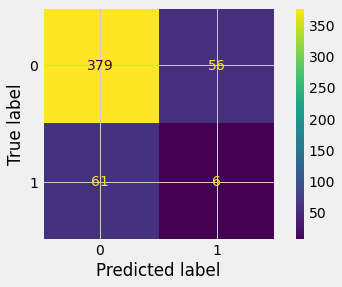

In [ ]:
cm_test = confusion_matrix(results_tlbert.test,results_tlbert.pred)
ConfusionMatrixDisplay(cm_test).plot()
plt.show()

## Performance Benchmark
Let's compare the different models' performances by looking at the accuracy and F1-score

In [ ]:
def performance_model(model, X, y):

    y_pred = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
  
    model_performance = {'accuracy': accuracy,
                          'f1-score': f1,
                         'precision': precision}
  
    return model_performance

In [ ]:
logreg = performance_model(lr, xval, yval)
naiveb = performance_model(nb, xval, yval)
simple_model = performance_model(model_1,xval, yval)
BERT_model = performance_model(model_tlbert,text_val, y_val)
  
data_results = pd.DataFrame({'Logistic Regression':logreg,
                             'Multinomial Naive Bayes':naiveb,
                             'Sequential Simple Model':simple_model,
                             'BERT-Transfer learning Model':BERT_model}).transpose()
                             
data_results.iloc[:,:3]

16/16 [==============================] - 2s 63ms/step


,accuracy,f1-score,precision
Logistic Regression,0.853047,0.327869,0.526316
Multinomial Naive Bayes,0.808244,0.478049,0.404959
Sequential Simple Model,0.974910,0.915663,0.926829
BERT-Transfer learning Model,0.962151,0.852713,0.887097
